# Amazon Customer Feedback Classification

In [341]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

## Prepare data

In [364]:
#Read in data
df = pd.read_csv('amazon_cells_labelled.txt',sep='\t')
df.columns = ['message','sentiment']

In [365]:
#Create signal in data for reviews that are all in caps
df['allcaps'] = df.message.str.isupper()

In [388]:
#Create signals for key words that could be indicative of negative sentiment
keywords = ['low','crap','difficult','awful','refuse','refused','unreliable','horrible','fails','useless','strange','disappointment','disappointing','couldn\'t','forget','disappoint','only','too','cannot','refund','breaks','broken','disappointed','disappoint','poor','unusable','problem','don\'t','not','doesn\'t','waste','flaw','worst','junk','terrible','lacking','bad','never','broke','disappointed','but']

for key in keywords:
    df[str(key)] = df.message.str.contains(
    ' '+str(key)+' ',
        case=False
    )

In [389]:
#Identify whether or not comment was negative
df['negative_sentiment'] = (df['sentiment'] == 0)

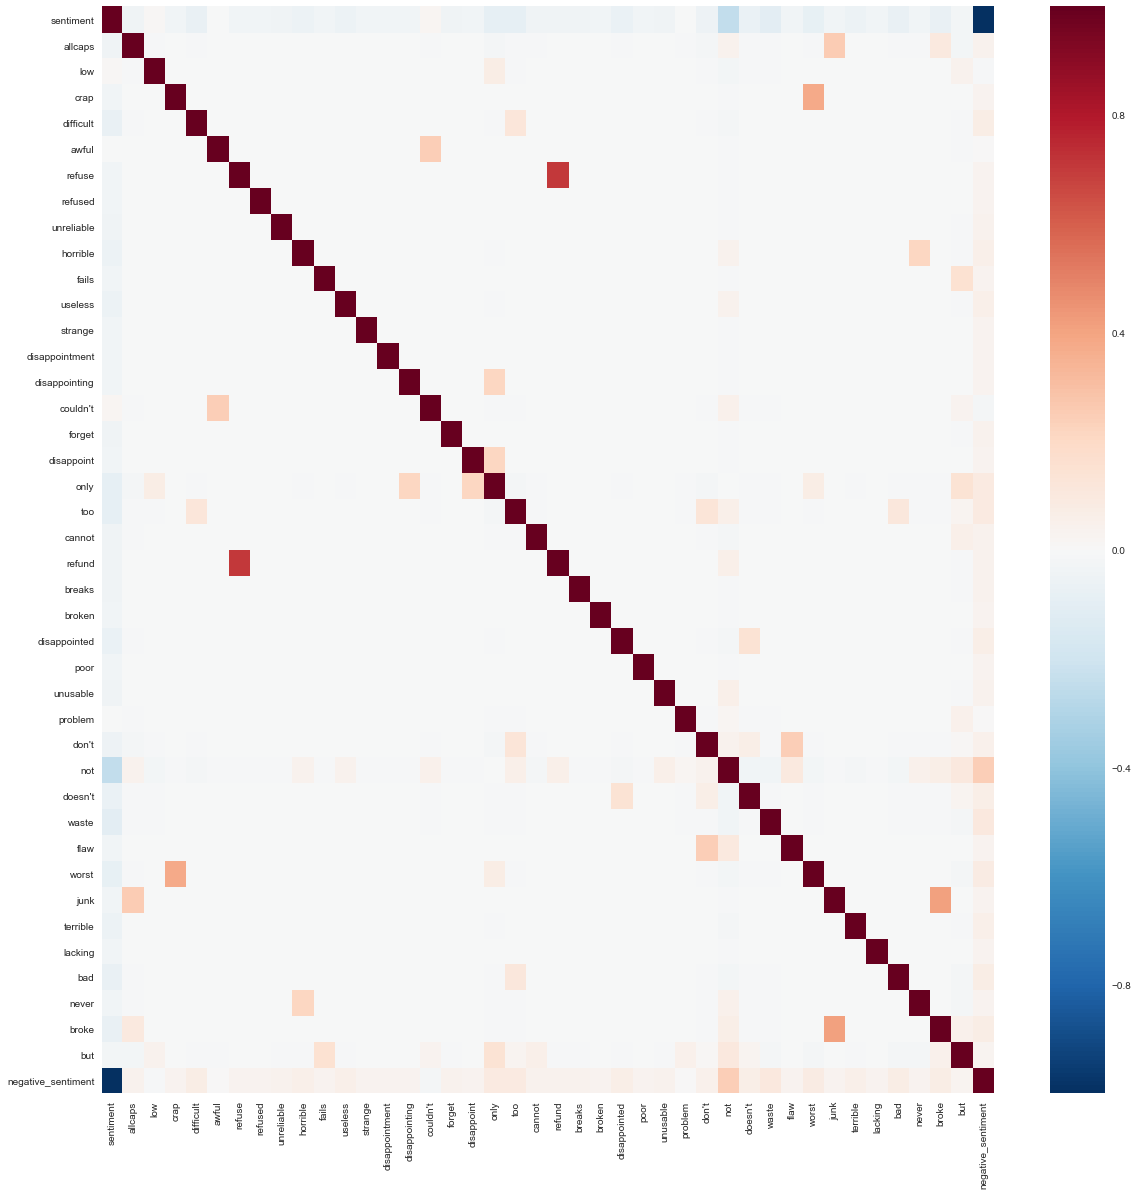

In [390]:
#Create heat map to make sure that there aren't any strong correlations between keywords
plt.figure(figsize=(20,20))
sns.heatmap(df.corr())

## Model Data

In [391]:
# Evaluate distribution of negative/positive comments to establish baseline for model performance. >50% performance is 
# better than chance. 
df['negative_sentiment'].value_counts()

False    500
True     499
Name: negative_sentiment, dtype: int64

### Performance without holdouts
The model performs moderately well when tested on itself

In [382]:
#Subset data frame into features and target
data = df[keywords +['allcaps']]
target = df['negative_sentiment']

from sklearn.naive_bayes import BernoulliNB

#Initialize Bernoulli Naive Bayes
bnb = BernoulliNB()

#Fit model to data and target
bnb.fit(data, target)

#Use model to predict sentiment
y_pred = bnb.predict(data)

#Evaluate performance
print("Number of mislabeled points out of a total {} points: {}".format(
data.shape[0],
(target != y_pred).sum()
))

print("Model was correct {} percent of the time.".format(
    ((target == y_pred).sum())/data.shape[0]))

Number of mislabeled points out of a total 999 points: 338
Model was correct 0.6616616616616616 percent of the time.


In [392]:
#Create confusion matrix to evaluate how model is behaving; in this case it tends to find more false positives than 
#negatives 
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

#308 false negatives, Type II errors, misses

#30 false positivies, Type I errors, false alarm

array([[470,  30],
       [308, 191]])

### Train on 70% of data set

To better evaluate the model performance, we'll train on a 70% of the data and test on the remaining 30%. In this case the model performs slightly worse.

In [402]:
#Create a holdout with 30% of the data 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)

train_data = train[keywords +['allcaps']]
train_target = train['negative_sentiment']

test_data = test[keywords +['allcaps']]
test_target = test['negative_sentiment']

In [407]:
from sklearn.naive_bayes import BernoulliNB

#Initialize model
bnb = BernoulliNB()

#Fit model to training data
bnb.fit(train_data, train_target)

#Run model on test data
y_pred = bnb.predict(test_data)

#Evaluate performance
print("Number of mislabeled points out of a total {} points: {}".format(
test_data.shape[0],
(test_target != y_pred).sum()
))

print("Model was correct {} percent of the time.".format(
    ((test_target == y_pred).sum())/test_data.shape[0]))

Number of mislabeled points out of a total 300 points: 114
Model was correct 0.62 percent of the time.


### 10-fold cross validation

Finally, a more robust approach would be crossvalidation. We'll use 10 folds. The model actually performs a little bit better compared to our previous test. The results of this cross validation gives good indication as to how well the model will actually perform with new data. 

In [408]:
#Initialize standardizer, pipeline and KFold
standardizer = StandardScaler()
pipeline = make_pipeline(standardizer, bnb)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [380]:
#Append results of crossvalidation to cv_results
cv_results = cross_val_score(pipeline, 
                             data, 
                             target, 
                             cv=kf, 
                             scoring="accuracy", 
                             n_jobs=-1)

In [409]:
#Evaluate performance
cv_results.mean()

0.64160606060606074